In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import math
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle
import sys
import getpass
if not os.path.isfile('model_module.py') or not os.path.isfile('plot_module.py'):
    current_path = os.path.dirname(os.path.abspath('__file__'))
    additional_path = '/'.join(current_path.split('/')[:-1])
    sys.path.append(additional_path)
    
from plot_module import text_plot
from plot_module import structure_vocabulary_plots
from plot_module import text_boundaries_plot
from plot_module import ComparePlots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL




version = sys.version_info[0]

In [2]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'wb')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'rb')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

In [3]:
f = open('enwik8_clean2', 'rb')
text = f.read().decode('utf8')
print(len(text))
f.close() 
(not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)


56184664


In [4]:
#different
offset_1 = 0
offset_2 = 4100
valid_size_1 = 4000
valid_size_2 = 4000
valid_text_1 = text[offset_1:offset_1+valid_size_1]
valid_text_2 = text[offset_2:offset_2+valid_size_2]
train_text = text[offset_2+valid_size_2:]
train_size = len(train_text)

In [5]:
#different
offset = 20000
valid_size = 500
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)

In [6]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        if version >= 3:
            vocabulary.append(chr(i))
        else:
            vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)

print(vocabulary)
string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print(string_vocabulary)

['\t', '\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
	
 !"'(),-.?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [7]:
# This class implements hierarchical LSTM described in the paper https://arxiv.org/pdf/1609.01704.pdf
# All variables names and formula indices are taken from mentioned article
# notation A^i stands for A with upper index i
# notation A_i stands for A with lower index i
# notation A^i_j stands for A with upper index i and lower index j
class HM_LSTM(MODEL):
    
        
    def L2_norm(self,
                tensor,
                dim,
                appendix,
                keep_dims=True):
        with tf.name_scope('L2_norm'+appendix):
            square = tf.square(tensor, name="square_in_L2_norm")
            reduced = tf.reduce_mean(square,
                                     dim,
                                     keep_dims=keep_dims,
                                     name="reduce_mean_in_L2_norm")
            return tf.sqrt(reduced, name="L2_norm")
    
    
    def not_last_layer(self,
                       idx,                   # layer number (from 0 to self._num_layers - 1)
                       state,                 # A tuple of tensors containing h^l_{t-1}, c^l_{t-1} and z^l_{t-1}
                       bottom_up,             # A tensor h^{l-1}_t  
                       top_down,              # A tensor h^{l+1}_{t-1}
                       boundary_state_down):   # A tensor z^{l-1}_t

        # method implements operations (2) - (7) (shortly (1)) performed on idx-th layer
        # ONLY NOT FOR LAST LAYER! Last layer computations are implemented in self.last_layer method
        # and returns 3 tensors: hidden state, memory state
        # and boundary state (h^l_t, c^l_t and z^l_t accordingly)
        
        with tf.name_scope('LSTM_layer_%s'%(idx)):
            # batch_size of processed data
            current_batch_size = bottom_up.get_shape().as_list()[0]

            one = tf.constant([[1.]], name="one_constant")
            # note: in several next operations tf.transpose method is applied repeatedly.
            #       It was used for broadcasting activation along vectors in same batches

            # following operation computes a product z^l_{t-1} x h^{l+1}_{t-1} for formula (6)
            top_down_prepaired = tf.transpose(tf.multiply(tf.transpose(state[2],
                                                                       name="transposed_state2_in_top_down_prepaired"),
                                                          tf.transpose(top_down,
                                                                       name="transposed_top_down_in_top_down_prepaired"),
                                                          name="multiply_in_top_down_prepaired"),
                                              name="top_down_prepaired")

            # this one cumputes a product z^{l-1}_t x h^{l-1}_t for formula (7)
            bottom_up_prepaired = tf.transpose(tf.multiply(tf.transpose(boundary_state_down,
                                                                        name="transposed_boundary_state_down_in_bottom_down_prepaired"),
                                                           tf.transpose(bottom_up,
                                                                        name="transposed_bottom_up_in_bottom_up_prepaired"),
                                                           name="multiply_in_bottom_up_prepaired"),
                                               name="bottom_up_prepaired")
            
            boundary_state_reversed = tf.subtract(one, state[2], name="boundary_state_reversed")
            state0_prepaired = tf.transpose(tf.multiply(tf.transpose(boundary_state_reversed,
                                                                     name="transposed_boundary_state_reversed_in_state0_prepaired"),
                                                        tf.transpose(state[0],
                                                                     name="transposed_state0_state0_prepaired"),
                                                        name="multiply_in_state0_prepaired"),
                                            name="state0_prepaired")
            

            # Matrix multiplications in formulas (5) - (7) and sum in argument of function f_slice
            # in formula (4) are united in one operation
            # Matrices U^l_l, U^l_{l+1} and W^l_{l-1} are concatenated into one matrix self.Matrices[idx]
            # and vectors h^l_{t-1}, z^l_{t-1} x h^{l+1}_{t-1} and  z^{l-1}_t x h^{l-1}_t are 
            # concatenated into vector X
            X = tf.concat([bottom_up_prepaired, state0_prepaired, top_down_prepaired],
                          1,
                          name="X")
            concat = tf.add(tf.matmul(X,
                                      self.Matrices[idx],
                                      name="matmul_in_concat"),
                            self.Biases[idx],
                            name="concat")

            # following operations implement function vector implementation in formula (4)
            # and compute f^l_t, i^l_t, o^l_t, g^l_t and z^l_t
            [sigmoid_arg, tanh_arg, hard_sigm_arg] = tf.split(concat,
                                                              [3*self._num_nodes[idx], self._num_nodes[idx], 1],
                                                              axis=1,
                                                              name="split_to_function_arguments")
            
            L2_norm_of_hard_sigm_arg = self.L2_norm(hard_sigm_arg,
                                                    1,
                                                    "_hard_sigm")
            
            gate_concat = tf.sigmoid(sigmoid_arg, name="gate_concat")
            [forget_gate, input_gate, output_gate] = tf.split(gate_concat,
                                                              3,
                                                              axis=1,
                                                              name="split_to_gates_op")
            L2_forget_gate = self.L2_norm(forget_gate, None, 'forget_gate_layer%s' % idx, keep_dims=False)
            modification_vector = tf.tanh(tanh_arg, name="modification_vector")
            # self.compute_boundary_state works as step function in forward pass
            # and as hard sigm in backward pass 
            boundary_state = self.compute_boundary_state(hard_sigm_arg) 

            # Next operations implement c^l_t vector modification and h^l_t computing according to (2) and (3)
            # Since compute_boundary_state is the step function in forward pass
            # (if argument is greater than zero z^l_t = 1, otherwise z^l_t = 0)
            # equation (2) can be implemented either using tf.cond op
            # or via summing of all options multiplied flag which value is
            # equal to 0 or 1. I preferred the second variant because it doesn't involve
            # splitting input into batches and processing them separately.
            # In this algorithm I used 3 flags: update_flag, copy_flag and flush_flag
            # update_flag = 1 if UPDATE and 0 otherwise
            # copy_flag = 1 if COPY and 0 otherwise
            # flush_flag = 1 if FLUSH and 0 otherwise
            # flags, gates and vectors are transposed for broadcasting
            with tf.name_scope('boundary_operations'):
                update_flag = tf.transpose(tf.to_float(tf.logical_and(tf.equal(state[2],
                                                                               [[0.]],
                                                                               name="equal_state2_and_0_in_update_flag"),
                                                                      tf.equal(boundary_state_down,
                                                                               [[1.]],
                                                                               name="equal_boundary_state_down_and_1_in_update_flag"),
                                                                      name="logical_and_in_update_flag"),
                                                       name="to_float_in_update_flag"),
                                           name="update_flag")
                copy_flag = tf.transpose(tf.to_float(tf.logical_and(tf.equal(state[2],
                                                                             [[0.]],
                                                                             name="equal_state2_and_0_in_copy_flag"),
                                                                    tf.equal(boundary_state_down,
                                                                             [[0.]],
                                                                             name="equal_boundary_state_down_and_0_in_copy_flag"),
                                                                    name="logical_and_in_copy_flag"),
                                                     name="to_float_in_copy_flag"),
                                         name="copy_flag")
                flush_flag = tf.transpose(tf.to_float(tf.equal(state[2],
                                                               [[1.]],
                                                               name="equal_state2_and_1_in_flush_flag"),
                                                      name="to_float_in_flush_flag"),
                                          name="flush_flag")
                # constant 'one' is used for building negations
                one = tf.constant([[1.]], name="one_constant")
                tr_memory = tf.transpose(state[1], name="tr_memory")
                tr_forget_gate = tf.transpose(forget_gate, name="tr_forget_gate")
                tr_input_gate = tf.transpose(input_gate, name="tr_input_gate")
                tr_output_gate = tf.transpose(output_gate, name="tr_output_gate")
                tr_modification_vector = tf.transpose(modification_vector, name="tr_modification_vector")
                # new memory computation
                update_term = tf.multiply(update_flag,
                                          tf.add(tf.multiply(tr_forget_gate,
                                                             tr_memory,
                                                             name="multiply_forget_and_memory_in_update_term"),
                                                 tf.multiply(tr_input_gate,
                                                             tr_modification_vector,
                                                             name="multiply_input_and_modification_in_update_term"),
                                                 name="add_in_update_term"),
                                          name="update_term")
                copy_term = tf.multiply(copy_flag, tr_memory, name="copy_term")

                
                flush_term = tf.multiply(flush_flag,
                                         tf.multiply(tr_input_gate,
                                                     tr_modification_vector,
                                                     name="multiply_input_and_modification_in_flush_term"),
                                         name="flush_term")
                
                tr_new_memory = tf.add(tf.add(update_term,
                                              copy_term,
                                              name="add_update_and_copy_in_tr_new_memory"),
                                       flush_term,
                                       name="tr_new_memory")
                new_memory = tf.transpose(tr_new_memory, name="new_memory")
                # new hidden states computation
                tr_hidden = tf.transpose(state[0], name="tr_hidden")
                copy_term = tf.multiply(copy_flag, tr_hidden, name="copy_term_for_hidden")
                else_term = tf.multiply(tf.multiply(tf.subtract(one,
                                                                copy_flag,
                                                                name="subtract_in_else_term"),
                                                    tr_output_gate,
                                                    name="multiply_subtract_and_tr_output_gate_in_else_term"),
                                        tf.tanh(tr_new_memory, name="tanh_in_else_term"),
                                        name="else_term")
                new_hidden = tf.transpose(tf.add(copy_term, else_term, name="new_hidden"),
                                          name="new_hidden")
                
                helper = {"L2_norm_of_hard_sigm_arg": L2_norm_of_hard_sigm_arg,
                          "hard_sigm_arg": hard_sigm_arg,
                          "L2_forget_gate": L2_forget_gate}
        return new_hidden, new_memory, boundary_state, helper
    
    def last_layer(self,
                   state,                 # A tuple of tensors containing h^L_{t-1}, c^L_{t-1} (L - total number of layers)
                   bottom_up,             # A tensor h^{L-1}_t  
                   boundary_state_down):   # A tensor z^{L-1}_t
        # method implements operations (2) - (7) (shortly (1)) performed on the last layer
        # and returns 2 tensors: hidden state, memory state (h^L_t, c^L_t accordingly)
        
        with tf.name_scope('LSTM_layer_%s' % (self._num_layers-1)):
            # batch_size of processed data
            current_batch_size = bottom_up.get_shape().as_list()[0]
            # last layer idx
            last = self._num_layers-1


            # note: in several next operations tf.transpose method is applied repeatedly.
            #       It was used for broadcasting activation along vectors in same batches

            # this one cumputes a product z^{l-1}_t x h^{l-1}_t for formula (7)
            bottom_up_prepaired = tf.transpose(tf.multiply(tf.transpose(boundary_state_down,
                                                                        name="transposed_boundary_state_down_in_bottom_down_prepaired"),
                                                           tf.transpose(bottom_up,
                                                                        name="transposed_bottom_up_in_bottom_up_prepaired"),
                                                           name="multiply_in_bottom_up_prepaired"),
                                               name="bottom_up_prepaired")

            # Matrix multiplications in formulas (5) - (7) and sum in argument of function f_slice
            # in formula (4) are united in one operation
            # Matrices U^l_l and W^l_{l-1} are concatenated into one matrix self.Matrices[last] 
            # and vectors h^l_{t-1} and  z^{l-1}_t x h^{l-1}_t are concatenated into vector X
            X = tf.concat([bottom_up_prepaired, state[0]],
                          1,
                          name="X")                                          
            concat = tf.add(tf.matmul(X,
                                      self.Matrices[last],
                                      name="matmul_in_concat"),
                            self.Biases[last],
                            name="concat")

            # following operations implement function vector implementation in formula (4)
            # and compute f^l_t, i^l_t, o^l_t, g^l_t and z^l_t
            # Note that that 'hard sigm' is omitted
            [sigmoid_arg, tanh_arg] = tf.split(concat, 
                                               [3*self._num_nodes[last], self._num_nodes[last]],
                                               axis=1,
                                               name="split_to_function_arguments")                                          
            gate_concat = tf.sigmoid(sigmoid_arg, name="gate_concat")
            [forget_gate, input_gate, output_gate] = tf.split(gate_concat,
                                                              3,
                                                              axis=1,
                                                              name="split_to_gates_op")
            L2_forget_gate = self.L2_norm(forget_gate,
                                          None,
                                          "forget_gate_layer%s"%(self._num_layers-1),
                                          keep_dims=False)
            modification_vector = tf.tanh(tanh_arg, name="modification_vector")

            # Next operations implement c^l_t vector modification and h^l_t computing according to (2) and (3)
            # Check up detailed description in previous method's comments 
            # I used 2 flags: update_flag and copy_flag 
            # update_flag = 1 if UPDATE and 0 otherwise
            # copy_flag = 1 if COPY and 0 otherwise
            # flags, gates and vectors are transposed for broadcasting
            with tf.name_scope('boundary_operations'):
                update_flag = tf.transpose(tf.to_float(tf.equal(boundary_state_down,
                                                                1.,
                                                                name="equal_boundary_state_down_and_1_in_update_flag"),
                                                       name="to_float_in_update_flag"),
                                           name="update_flag")
                # constant 'one' is used for building negations
                one = tf.constant([[1.]], name="one_constant")
                copy_flag = tf.subtract(one, update_flag, name="copy_flag")
                tr_memory = tf.transpose(state[1], name="tr_memory")
                tr_forget_gate = tf.transpose(forget_gate, name="tr_forget_gate")
                tr_input_gate = tf.transpose(input_gate, name="tr_input_gate")
                tr_output_gate = tf.transpose(output_gate, name="tr_output_gate")
                tr_modification_vector = tf.transpose(modification_vector, name="tr_modification_gate")
                # new memory computation
                update_term = tf.multiply(update_flag,
                                          tf.add(tf.multiply(tr_forget_gate,
                                                             tr_memory,
                                                             name="multiply_forget_and_memory_in_update_term"),
                                                 tf.multiply(tr_input_gate,
                                                             tr_modification_vector,
                                                             name="multiply_input_and_modification_in_update_term"),
                                                 name="add_in_update_term"),
                                          name="update_term")
                copy_term = tf.multiply(copy_flag, tr_memory, name="copy_term")
                tr_new_memory = tf.add(update_term,
                                       copy_term,
                                       name="tr_new_memory")
                new_memory = tf.transpose(tr_new_memory, name="new_memory")
                # new hidden states computation
                tr_hidden = tf.transpose(state[0], name="tr_hidden")
                copy_term = tf.multiply(copy_flag, tr_hidden, name="copy_term_for_hidden")
                else_term = tf.multiply(tf.multiply(tf.subtract(one,
                                                                copy_flag,
                                                                name="subtract_in_else_term"),
                                                    tr_output_gate,
                                                    name="multiply_subtract_and_tr_output_gate_in_else_term"),
                                        tf.tanh(tr_new_memory, name="tanh_in_else_term"),
                                        name="else_term")
                new_hidden = tf.transpose(tf.add(copy_term, else_term, name="new_hidden"),
                                          name="new_hidden")
                helper = {"L2_forget_gate": L2_forget_gate}
        return new_hidden, new_memory, helper
     
    
    def compute_boundary_state(self,
                               X):
        # Elementwise calculates step function 
        # During backward pass works as hard sigm
        with self._graph.gradient_override_map({"Sign": self.gradient_name}):
            X = tf.sign(X, name="sign_func_in_compute_boundary")
        """X = tf.sign(X)"""
        X = tf.divide(tf.add(X,
                             tf.constant([[1.]]),
                             name="add_in_compute_boundary_state"),
                      2.,
                      name="output_of_compute_boundary_state")
        return X
    
    def iteration(self, inp, state, iter_idx):
        # This function implements processing of one character embedding by HM_LSTM
        # 'inp' is one character embedding
        # 'state' is network state from previous layer
        # Method returns: new state of the network which includes hidden states,
        # memory states and boundary states for all layers; concatenated boundaries for all
        # layers ([batch_size, self._num_layers-1])
        
        with tf.name_scope('iteration_%s'%iter_idx):

            num_layers = self._num_layers
            new_state = list()
            boundaries = list()
            helpers = list()

            # batch_size of processed data
            current_batch_size = state[0][0].get_shape().as_list()[0]
            # activated_boundary_states variable is used as boundary_state_down
            # argument on the first layer
            activated_boundary_states = tf.constant(1.,
                                                    shape=[current_batch_size, 1],
                                                    name="activated_boundary_states_in_iteration_function")

            # The first layer is calculated outside the loop

            hidden = inp
            boundary = activated_boundary_states
            # All layers except for the first and the last ones
            for idx in range(num_layers-1):
                hidden, memory, boundary, helper = self.not_last_layer(idx,
                                                                       state[idx],
                                                                       hidden,
                                                                       state[idx+1][0],
                                                                       boundary)
                helpers.append(helper)
                new_state.append((hidden, memory, boundary))
                boundaries.append(boundary)
            hidden, memory, helper = self.last_layer(state[-1],
                                                     hidden,
                                                     boundary)
            helpers.append(helper)
            new_state.append((hidden, memory))
            L2_norm_of_hard_sigm_arg_list = list()
            helper = {"L2_norm_of_hard_sigm_arg": tf.concat([helper["L2_norm_of_hard_sigm_arg"] for helper in helpers[:-1]],
                                                            1,
                                                            name="L2_norm_of_hard_sigm_arg_for_all_layers"),
                      "hard_sigm_arg": tf.concat([helper["hard_sigm_arg"] for helper in helpers[:-1]],
                                                 1,
                                                 name="hard_sigm_arg_for_all_layers"),
                      "L2_forget_gate": tf.stack([helper["L2_forget_gate"] for helper in helpers],
                                                 name="L2_forget_gate_for_iteration%s"%iter_idx)}
            return new_state, tf.concat(boundaries, 1, name="iteration_boundaries_output"), helper
    
    def embedding_module(self,
                         inputs):
        # This function embeds input one-hot encodded character vector into a vector of dimension embedding_size
        # For computation acceleration inputs are concatenated before being multiplied on self.embedding_weights
        with tf.name_scope('embedding_module'):
            current_num_unrollings = len(inputs)
            inputs = tf.concat(inputs,
                               0,
                               name="inputs_concat_in_embedding_module")
            embeddings = tf.matmul(inputs,
                                   self.embedding_weights,
                                   name="concatenated_embeddings_in_embedding_module")
            return tf.split(embeddings,
                            current_num_unrollings,
                            axis=0,
                            name="embedding_module_output")
    
    
    def RNN_module(self,
                   embedded_inputs,
                   saved_state):
        # This function implements processing of embedded inputs by HM_LSTM
        # Function returns: state of recurrent neural network after last character processing 'state',
        # hidden states obtained on each character 'saved_hidden_states' and boundaries on each layer 
        # on all characters.
        # Method returns 'state' state of network after last iteration (list of tuples (one tuple for each
        # layer), tuple contains hidden state ([batch_size, self._num_nodes[idx]]), memory state
        # ([batch_size, self._num_nodes[idx]]) and boundary state ([batch_size, 1])), list of concatenated along batch 
        # dimension hidden states for all layers 'saved_hidden_states' (each element of the list is tensor of dim 
        # [batch_size*num_unrollings, self._num_nodes[idx]]); a tensor containing L2 norms of hidden states
        # of shape [batch_size, num_unrollings, num_layers]
        with tf.name_scope('RNN_module'):
            # 'saved_hidden_states' is a list of self._num_layers elements. idx-th element of the list is 
            # a concatenation of hidden states on idx-th layer along chunk of input text.
            saved_hidden_states = list()
            for _ in range(self._num_layers):
                saved_hidden_states.append(list())

            # 'saved_iteration_boundaries' is a list
            saved_iteration_boundaries = list()
            state = saved_state
            iteration_helpers = list()
            for emb_idx, emb in enumerate(embedded_inputs):
                state, iteration_boundaries, helper = self.iteration(emb, state, emb_idx)
                iteration_helpers.append(helper)
                saved_iteration_boundaries.append(iteration_boundaries)
                for layer_state, saved_hidden in zip(state, saved_hidden_states):
                    saved_hidden.append(layer_state[0])
                    
            # computing l2 norm of hidden states
            with tf.name_scope('L2_norm'):
                # all hidden states are packed to form a tensor of shape 
                # [batch_size, num_unrollings]
                L2_norm_by_layers = list()
                current_batch_size = saved_hidden_states[0][0].get_shape().as_list()[0]
                shape = [current_batch_size, len(embedded_inputs)]

                for layer_idx, saved_hidden in enumerate(saved_hidden_states):
                    stacked_for_L2_norm = tf.stack(saved_hidden,
                                                   axis=1,
                                                   name="stacked_hidden_states_on_layer%s"%layer_idx)
                    L2_norm_by_layers.append(tf.reshape(self.L2_norm(stacked_for_L2_norm,
                                                                     2,
                                                                     "_for_layer%s" % layer_idx),
                                                        shape,
                                                        name="L2_norm_for_layer%s" % layer_idx))
                L2_norm = tf.stack(L2_norm_by_layers, axis=2, name="L2_norm")

            for idx, layer_saved in enumerate(saved_hidden_states):
                saved_hidden_states[idx] = tf.concat(layer_saved, 0, name="hidden_concat_in_RNN_module_on_layer%s"%idx)

            helper = {"L2_norm_of_hard_sigm_arg": tf.stack([helper["L2_norm_of_hard_sigm_arg"] for helper in iteration_helpers],
                                                           axis=1,
                                                           name="L2_norm_of_hard_sigm_arg_for_all_iterations"),
                      "hard_sigm_arg": tf.stack([helper["hard_sigm_arg"] for helper in iteration_helpers],
                                                axis=1,
                                                name="hard_sigm_arg_for_all_iterations"),
                      "all_boundaries": tf.stack(saved_iteration_boundaries,
                                                 axis=1,
                                                 name="stack_of_boundaries"),
                      "L2_norm_of_hidden_states": L2_norm,
                      "L2_forget_gate": tf.stack([helper['L2_forget_gate'] for helper in iteration_helpers],
                                                 name="L2_forget_gate_all")}
            return state, saved_hidden_states, helper
            
    
    def output_module(self,
                      hidden_states):
        with tf.name_scope('output_module'):
            concat = tf.concat(hidden_states, 1, name="total_concat_hidden")
            output_module_gates = tf.transpose(tf.sigmoid(tf.matmul(concat,
                                                                    self.output_module_gates_weights,
                                                                    name="matmul_in_output_module_gates"),
                                                          name="sigmoid_in_output_module_gates"),
                                               name="output_module_gates")
            output_module_gates = tf.split(output_module_gates,
                                           self._num_layers,
                                           axis=0,
                                           name="split_of_output_module_gates")
            tr_gated_hidden_states = list()
            for idx, hidden_state in enumerate(hidden_states):
                tr_hidden_state = tf.transpose(hidden_state, name="tr_hidden_state_total_%s"%idx)
                tr_gated_hidden_states.append(tf.multiply(output_module_gates[idx],
                                                          tr_hidden_state,
                                                          name="tr_gated_hidden_states_%s"%idx))
            gated_hidden_states = tf.transpose(tf.concat(tr_gated_hidden_states,
                                                         0,
                                                         name="concat_in_gated_hidden_states"),
                                               name="gated_hidden_states")
            output_embeddings = tf.nn.relu(tf.add(tf.matmul(gated_hidden_states,
                                                            self.output_embedding_weights,
                                                            name="matmul_in_output_embeddings"),
                                                  self.output_embedding_bias,
                                                  name="xW_plus_b_in_output_embeddings"),
                                           name="output_embeddings")
            return tf.add(tf.matmul(output_embeddings,
                                    self.output_weights,
                                    name="matmul_in_logits"),
                          self.output_bias,
                          name="logits")
        
    def compute_perplexity(self, probabilities):
        with tf.name_scope('perplexity'):
            ln2 = tf.log(2., name="ln2")
            too_small_mask = tf.to_float(tf.less(probabilities,
                                                 1e-10,
                                                 name="less_too_small_mask"),
                                         name="too_small_mask")
            not_small_mask = tf.subtract(1., too_small_mask, name="not_small_mask")
            too_small_term = tf.multiply(too_small_mask, 1e-10, name="too_small_term")
            not_small_term = tf.multiply(not_small_mask, probabilities, name="not_small_term")
            probabilities = tf.add(too_small_term, not_small_term, name="probabilities")
            log_probabilities = tf.divide(tf.log(probabilities, name="log_in_compute_probability"), ln2, name="log_probabilities")
            neg_probabilities = tf.negative(probabilities, name="negative_in_compute_probability")
            multiply = tf.multiply(neg_probabilities, log_probabilities, name="multiply_in_compute_probability")
            entropy = tf.reduce_sum(multiply, axis=1, name="entropy")
            perplexity = tf.exp(tf.multiply(ln2, entropy, name="multiply_in_perplexity"), name="perplexity")
            return tf.reduce_mean(perplexity, name="mean_perplexity")
            
    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_layers,
                 num_nodes,
                 init_slope,
                 slope_growth,
                 slope_half_life,
                 train_text,
                 valid_text,
                 embedding_size=128,
                 output_embedding_size=1024,
                 init_parameter=1.,               # init_parameter is used for balancing stddev in matrices initialization
                                                  # and initial learning rate
                 matr_init_parameter=1000.,
                 override_appendix='',
                 init_bias=-0.01):               
                                                   
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        self._num_unrollings = num_unrollings
        self._num_layers = num_layers
        self._num_nodes = num_nodes
        self._init_slope = init_slope
        self._slope_half_life = slope_half_life
        self._slope_growth = slope_growth
        self._train_text = train_text
        self._valid_text = valid_text
        self._valid_size = len(valid_text)
        self._embedding_size = embedding_size
        self._output_embedding_size = output_embedding_size
        self._init_parameter = init_parameter
        self._matr_init_parameter = matr_init_parameter
        self._init_bias = init_bias
        self.gradient_name = 'HardSigmoid' + override_appendix
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "half_life": 4,
                         "decay": 5,
                         "num_steps": 6,
                         "averaging_number": 7,
                         "init_slope": 8,
                         "slope_growth": 9,
                         "slope_half_life": 10,
                         "embedding_size": 11,
                         "output_embedding_size": 12,
                         "init_parameter": 13,
                         "matr_init_parameter": 14,
                         "init_bias":15,
                         "type": 16}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            tf.set_random_seed(1)
            with tf.name_scope('train'):
                self._global_step = tf.Variable(0, trainable=False, name="global_step")
            with self._graph.device('/gpu:0'):
                # embedding module variables
                self.embedding_weights = tf.Variable(tf.truncated_normal([self._vocabulary_size, self._embedding_size],
                                                                         stddev = math.sqrt(self._init_parameter*matr_init_parameter/self._vocabulary_size),
                                                                         name="embeddings_matrix_initialize"), 
                                                     name="embeddings_matrix_variable")
                
                # RNN module variables
                self.Matrices = list()
                self.Biases = list()
                
                # tensor name templates for HM_LSTM parameters
                init_matr_name = "HM_LSTM_matrix_%s_initializer"
                bias_name = "HM_LSTM_bias_%s" 
                matr_name = "HM_LSTM_matrix_%s"
                
                def compute_dim_and_bias(layer_idx):
                    bias_init_values = [0.]*(4*self._num_nodes[layer_idx])
                    if layer_idx == self._num_layers - 1:
                        input_dim = self._num_nodes[-1] + self._num_nodes[-2]
                        output_dim = 4 * self._num_nodes[-1]
                    else:
                        output_dim = 4 * self._num_nodes[layer_idx] + 1
                        bias_init_values.append(self._init_bias)
                        if layer_idx == 0:
                            input_dim = self._embedding_size + self._num_nodes[0] + self._num_nodes[1]
                        else:
                            input_dim = self._num_nodes[layer_idx - 1] + self._num_nodes[layer_idx] + self._num_nodes[layer_idx+1]
                    stddev = math.sqrt(self._init_parameter*matr_init_parameter/input_dim)
                    return input_dim, output_dim, bias_init_values, stddev
                
                for layer_idx in range(self._num_layers):
                    input_dim, output_dim, bias_init_values, stddev = compute_dim_and_bias(layer_idx)
                    self.Biases.append(tf.Variable(bias_init_values,
                                                   name=bias_name%layer_idx))         
                    self.Matrices.append(tf.Variable(tf.truncated_normal([input_dim,
                                                                          output_dim],
                                                                         mean=0.,
                                                                         stddev=stddev,
                                                                         name=init_matr_name%0),
                                                     name=matr_name%layer_idx))    

                dim_classifier_input = sum(self._num_nodes)
                
                # output module variables
                # output module gates weights (w^l vectors in (formula (11)))
                self.output_module_gates_weights = tf.Variable(tf.truncated_normal([dim_classifier_input, self._num_layers],
                                                                                   stddev = math.sqrt(self._init_parameter*matr_init_parameter/dim_classifier_input),
                                                                                   name="output_gates_weights_initializer"),
                                                               name="output_gates_weights")
                # classifier 
                self.output_embedding_weights = tf.Variable(tf.truncated_normal([dim_classifier_input, self._output_embedding_size],
                                                                                stddev=math.sqrt(self._init_parameter*matr_init_parameter/dim_classifier_input),
                                                                                name="output_embedding_weights_initializer"),
                                                            name="output_embedding_weights")
                self.output_embedding_bias = tf.Variable(tf.zeros([self._output_embedding_size], name="output_bias_initializer"),
                                                         name="output_embedding_bias")
                self.output_weights = tf.Variable(tf.truncated_normal([self._output_embedding_size, self._vocabulary_size],
                                                                      stddev = math.sqrt(self._init_parameter*matr_init_parameter/self._output_embedding_size),
                                                                      name="output_weights_initializer"),
                                                  name="output_weights")
                self.output_bias = tf.Variable(tf.zeros([self._vocabulary_size], name="output_bias_initializer"),
                                               name="output_bias")
                
                
                with tf.name_scope('train'):
                    """PLACEHOLDERS train data"""
                    # data input placeholder name template
                    inp_name_templ = "placeholder_inp_%s"
                    self._train_data = list()
                    for j in range(self._num_unrollings + 1):
                        self._train_data.append(
                            tf.placeholder(tf.float32,
                                           shape=[self._batch_size, self._vocabulary_size],
                                           name=inp_name_templ%j))
                    train_inputs = self._train_data[: self._num_unrollings]
                    train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                    # Unrolled LSTM loop.
                    train_inputs_for_slice = tf.stack(train_inputs,
                                                      axis=1,
                                                      name="train_inputs_for_slice")
                    self.train_input_print = tf.reshape(tf.split(train_inputs_for_slice,
                                                                 [1, self._batch_size-1],
                                                                 name="split_in_train_print")[0],
                                                        [self._num_unrollings, -1],
                                                        name="train_print")


                    self.saved_state = list()
                    # templates for saved_state tensor names
                    saved_state_init_templ = "saved_state_layer%s_number%s_initializer"
                    saved_state_templ = "saved_state_layer%s_number%s"
                    for i in range(self._num_layers-1):
                        self.saved_state.append((tf.Variable(tf.zeros([self._batch_size, self._num_nodes[i]],
                                                                      name=saved_state_init_templ%(i, 0)),
                                                             trainable=False,
                                                             name=saved_state_templ%(i, 0)),
                                                 tf.Variable(tf.zeros([self._batch_size, self._num_nodes[i]],
                                                                      name=saved_state_init_templ%(i, 1)),
                                                             trainable=False,
                                                             name=saved_state_templ%(i, 1)),
                                                 tf.Variable(tf.zeros([self._batch_size, 1],
                                                                      name=saved_state_init_templ%(i, 2)),
                                                             trainable=False,
                                                              name=saved_state_templ%(i, 2))))
                    self.saved_state.append((tf.Variable(tf.zeros([self._batch_size, self._num_nodes[-1]],
                                                                  name=saved_state_init_templ%(self._num_layers-1, 0)),
                                                         trainable=False,
                                                         name=saved_state_templ%(self._num_layers-1, 0)),
                                             tf.Variable(tf.zeros([self._batch_size, self._num_nodes[-1]],
                                                                  name=saved_state_init_templ%(self._num_layers-1, 1)),
                                                         trainable=False,
                                                         name=saved_state_templ%(self._num_layers-1, 1))))


                    # slope annealing trick
                    slope = tf.add(tf.constant(self._init_slope, name="init_slope_const"),
                                   tf.to_float((self._global_step / tf.constant(self._slope_half_life,
                                                                                dtype=tf.int32,
                                                                                name="slope_half_life_const")),
                                               name="to_float_in_slope_init") * tf.constant(self._slope_growth, name="slope_growth"),
                                   name="slope")
                    
                    @tf.RegisterGradient(self.gradient_name)
                    def hard_sigm_grad(op,                # op is operation for which gradient is computed
                                       grad):             # loss partial gradients with respect to op outputs
                        # This function is added for implememting straight-through estimator as described in
                        # 3.3 paragraph of fundamental paper. It is used during backward pass for replacing
                        # tf.sign function gradient. 'hard sigm' function derivative is 0 from minus
                        # infinity to -1/a, a/2 from -1/a to 1/a and 0 from 1/a to plus infinity. Since in
                        # compute_boundary_state function for implementing step function tf.sign product is
                        # divided by 2, in hard_sigm_grad output gradient is equal to 'a', not to 'a/2' from
                        # -1/a to 1/a in order to compensate mentioned multiplication in compute_boundary_state
                        # function
                        op_input = op.inputs[0]
                        # slope is parameter 'a' in 'hard sigm' function
                        mask = tf.to_float(tf.logical_and(tf.greater_equal(op_input, -1./ slope, name="greater_equal_in_hard_sigm_mask"),
                                                          tf.less(op_input, 1. / slope, name="less_in_hard_sigm_mask"),
                                                          name="logical_and_in_hard_sigm_mask"),
                                           name="mask_in_hard_sigm")
                        return tf.multiply(slope,
                                           tf.multiply(grad,
                                                       mask,
                                                       name="grad_mask_multiply_in_hard_sigm"),
                                           name="hard_sigm_grad_output")

                    embedded_inputs = self.embedding_module(train_inputs)
                    state, hidden_states, train_helper = self.RNN_module(embedded_inputs, self.saved_state)
                    logits = self.output_module(hidden_states)
                    
                    self.L2_train = tf.reshape(tf.slice(train_helper["L2_norm_of_hidden_states"],
                                                        [0, 0, 0],
                                                        [1, 10, 1],
                                                        name="slice_for_L2"),
                                               [-1],
                                               name="L2")
                    
                    self.train_hard_sigm_arg = tf.reshape(tf.split(train_helper["hard_sigm_arg"],
                                                                   [1, self._batch_size-1],
                                                                   name="split_in_train_hard_sigm_arg")[0],
                                                          [self._num_unrollings, -1],
                                                          name="train_hard_sigm_arg")
                    
                    L2_forget_gate_reduced = tf.reduce_mean(train_helper['L2_forget_gate'],
                                                            axis=0,
                                                            name="L2_forget_gate_reduced")
                    
                    self.L2_forget_gate = tf.unstack(L2_forget_gate_reduced, name="L2_forget_gate_unstacked")
                    
                    flush_fractions_stacked = tf.reduce_mean(train_helper['all_boundaries'],
                                                             axis=[0, 1],
                                                             name='flush_fractions_stacked')
                    
                    self.flush_fractions = tf.split(flush_fractions_stacked,
                                                    self._num_layers-1,
                                                    axis=0,
                                                    name='flush_fractions')
                    
                    L2_hard_sigm_arg_stacked = self.L2_norm(train_helper['hard_sigm_arg'],
                                                            [0, 1],
                                                            'hard_sigm_arg_stacked',
                                                            keep_dims=False)
                    
                    self.L2_hard_sigm_arg = tf.split(L2_hard_sigm_arg_stacked,
                                                     self._num_layers-1,
                                                     name='hard_sigm_arg')

                    save_list = list()
                    save_list_templ = "save_list_assign_layer%s_number%s"
                    for i in range(self._num_layers-1):
                        save_list.append(tf.assign(self.saved_state[i][0],
                                                   state[i][0],
                                                   name=save_list_templ%(i, 0)))
                        save_list.append(tf.assign(self.saved_state[i][1],
                                                   state[i][1],
                                                   name=save_list_templ%(i, 1)))
                        save_list.append(tf.assign(self.saved_state[i][2],
                                                   state[i][2],
                                                   name=save_list_templ%(i, 2)))
                    save_list.append(tf.assign(self.saved_state[-1][0],
                                               state[-1][0],
                                               name=save_list_templ%(self._num_layers-1, 0)))
                    save_list.append(tf.assign(self.saved_state[-1][1],
                                               state[-1][1],
                                               name=save_list_templ%(self._num_layers-1, 1)))

                    """skip operation"""
                    self._skip_operation = tf.group(*save_list, name="skip_operation")

                    with tf.control_dependencies(save_list):
                            # Classifier.
                        """loss"""
                        self._loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.concat(train_labels,
                                                                                                             0,
                                                                                                             name="train_labels_concat_for_cross_entropy"),
                                                                                            logits=logits,
                                                                                            name="cross_entropy"),
                                                    name="reduce_mean_for_loss_computation")
                    # Optimizer.

                    # global variables initializer
                    self.global_initializer = tf.global_variables_initializer()

                    """PLACEHOLDERS half life and decay"""
                    self._half_life = tf.placeholder(tf.int32, name="half_life")
                    self._decay = tf.placeholder(tf.float32, name="decay")
                    """learning rate"""
                    
                    # A list of first dimensions of all matrices
                    # It is used for defining initial learning rate
                    dimensions = list()
                    dimensions.append(self._vocabulary_size)
                    dimensions.append(self._embedding_size + self._num_nodes[0] + self._num_nodes[1])
                    if self._num_layers > 2:
                        for i in range(self._num_layers-2):
                            dimensions.append(self._num_nodes[i] + self._num_nodes[i+1] + self._num_nodes[i+2])
                    dimensions.append(sum(self._num_nodes))
                    max_dimension = max(dimensions)
                    
                    self._learning_rate = tf.train.exponential_decay(160.*math.sqrt(self._init_parameter/max_dimension),
                                                                     self._global_step,
                                                                     self._half_life,
                                                                     self._decay,
                                                                     staircase=True,
                                                                     name="learning_rate")
                    #optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)
                    optimizer = tf.train.AdamOptimizer(learning_rate=self._learning_rate)
                    gradients, v = zip(*optimizer.compute_gradients(self._loss))
                    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
                    """optimizer"""
                    self._optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)
                    """train prediction"""
                    self._train_prediction = tf.nn.softmax(logits, name="train_prediction")
                    print_list = tf.split(self._train_prediction, self._num_unrollings, name="print_list")
                    print_for_slice = tf.stack(print_list, axis=1, name="print_for_slice")
                    self.train_output_print = tf.reshape(tf.split(print_for_slice,
                                                                  [1, self._batch_size-1],
                                                                  name="split_in_train_print")[0],
                                                         [self._num_unrollings, -1],
                                                         name="train_print")
                    self.train_perplexity = self.compute_perplexity(self._train_prediction)
                    

                # Sampling and validation eval: batch 1, no unrolling.
                with tf.name_scope('validation'):
                    saved_sample_state = list()
                    saved_state_init_templ = "saved_sample_state_layer%s_number%s_initializer"
                    saved_state_templ = "saved_sample_state_layer%s_number%s"
                    for i in range(self._num_layers-1):
                        saved_sample_state.append((tf.Variable(tf.zeros([1, self._num_nodes[i]],
                                                                        name=saved_state_init_templ%(i, 0)),
                                                               trainable=False,
                                                               name=saved_state_templ%(i, 0)),
                                                   tf.Variable(tf.zeros([1, self._num_nodes[i]],
                                                                        name=saved_state_init_templ%(i, 1)),
                                                               trainable=False,
                                                               name=saved_state_templ%(i, 1)),
                                                   tf.Variable(tf.zeros([1, 1],
                                                                        name=saved_state_init_templ%(i, 2)),
                                                               trainable=False,
                                                               name=saved_state_templ%(i, 2))))
                    saved_sample_state.append((tf.Variable(tf.zeros([1, self._num_nodes[-1]],
                                                                    name=saved_state_init_templ%(self._num_layers-1, 0)),
                                                           trainable=False,
                                                           name=saved_state_templ%(self._num_layers-1, 0)),
                                               tf.Variable(tf.zeros([1, self._num_nodes[-1]],
                                                                    name=saved_state_init_templ%(self._num_layers-1, 1)),
                                                           trainable=False,
                                                           name=saved_state_templ%(self._num_layers-1, 1))))

                    # validation initializer. 
                    validation_initializer_list = list()
                    for saved_layer_sample_state in saved_sample_state:
                        for tensor in saved_layer_sample_state:
                            validation_initializer_list.append(tensor)
                    validation_initilizer = tf.variables_initializer(validation_initializer_list, name="validation_initializer")
                    """PLACEHOLDER sample input"""
                    self._sample_input = tf.placeholder(tf.float32,
                                                        shape=[1, self._vocabulary_size],
                                                        name="sample_input_placeholder")

                    reset_list_templ = "reset_list_assign_layer%s_number%s"
                    saved_state_init_templ = "saved_state_layer%s_number%s_initializer"
                    reset_list = list()
                    for i in range(self._num_layers-1):
                        reset_list.append(tf.assign(saved_sample_state[i][0],
                                                    tf.zeros([1, self._num_nodes[i]],
                                                             name=saved_state_init_templ%(i, 0)),
                                                    name=reset_list_templ%(i, 0)))
                        reset_list.append(tf.assign(saved_sample_state[i][1],
                                                    tf.zeros([1, self._num_nodes[i]],
                                                             name=saved_state_init_templ%(i, 1)),
                                                    name=reset_list_templ%(i, 1)))
                        reset_list.append(tf.assign(saved_sample_state[i][2],
                                                    tf.zeros([1, 1],
                                                             name=saved_state_init_templ%(i, 2)),
                                                    name=reset_list_templ%(i, 2)))
                    reset_list.append(tf.assign(saved_sample_state[-1][0],
                                                tf.zeros([1, self._num_nodes[-1]],
                                                         name=saved_state_init_templ%(self._num_layers-1, 0)),
                                                name=reset_list_templ%(self._num_layers-1, 0)))
                    reset_list.append(tf.assign(saved_sample_state[-1][1],
                                                tf.zeros([1, self._num_nodes[-1]],
                                                         name=saved_state_init_templ%(self._num_layers-1, 1)),
                                                name=reset_list_templ%(self._num_layers-1, 1)))
                    #reset sample state
                    self._reset_sample_state = tf.group(*reset_list, name="reset_sample_state")


                    sample_embedded_inputs = self.embedding_module([self._sample_input])
                    sample_state, sample_hidden_states, validation_helper = self.RNN_module(sample_embedded_inputs,
                                                                                            saved_sample_state)
                    sample_logits = self.output_module(sample_hidden_states) 

                    sample_save_list = list()
                    save_list_templ = "save_sample_list_assign_layer%s_number%s"
                    for i in range(self._num_layers-1):
                        sample_save_list.append(tf.assign(saved_sample_state[i][0],
                                                          sample_state[i][0],
                                                          name=save_list_templ%(i, 0)))
                        sample_save_list.append(tf.assign(saved_sample_state[i][1],
                                                          sample_state[i][1],
                                                          name=save_list_templ%(i, 1)))
                        sample_save_list.append(tf.assign(saved_sample_state[i][2],
                                                          sample_state[i][2],
                                                          name=save_list_templ%(i, 2)))
                    sample_save_list.append(tf.assign(saved_sample_state[-1][0],
                                                      sample_state[-1][0],
                                                      name=save_list_templ%(self._num_layers-1, 0)))
                    sample_save_list.append(tf.assign(saved_sample_state[-1][1],
                                                      sample_state[-1][1],
                                                      name=save_list_templ%(self._num_layers-1, 1)))

                    with tf.control_dependencies(sample_save_list):
                        """sample prediction"""
                        self._sample_prediction = tf.nn.softmax(sample_logits, name="sample_prediction") 
                        self.L2_hidden_states_validation = tf.reshape(validation_helper["L2_norm_of_hidden_states"], [-1], name="L2_hidden_validation")
                        self.boundary = tf.reshape(validation_helper["all_boundaries"], [-1], name="sample_boundary")
                        self.sigm_arg = tf.reshape(validation_helper["hard_sigm_arg"], [-1], name="sample_sigm_arg")
                        self.validation_perplexity = self.compute_perplexity(self._sample_prediction)
                # creating control dictionary
                all_vars = tf.global_variables()
                self.control_dictionary = dict()
                #print('building graph')
                for variable in all_vars:
                    
                    list_to_form_name = variable.name.split('/')
                    if ':' in list_to_form_name[-1]:
                        list_to_form_name[-1] = list_to_form_name[-1].split(':')[0]
                    if len(list_to_form_name) < 2:
                        name = list_to_form_name[0] 
                    else:
                        name = list_to_form_name[0] + '_' + list_to_form_name[-1]
                    norm = self.L2_norm(tf.to_float(variable,
                                                    name="to_float_in_control_dictionary_for_"+list_to_form_name[-1]),
                                        None,
                                        list_to_form_name[-1],
                                        keep_dims=False)
                    with tf.device('/cpu:0'):
                        self.control_dictionary[name] = tf.summary.scalar(name+'_sum', 
                                                                          norm)
                    #print(name, ': ', norm.get_shape().as_list())
            forget_template = 'self.L2_forget_gate[%s]'
            flush_fractions_template = 'self.flush_fractions[%s]'
            L2_hard_sigm_template = 'self.L2_hard_sigm_arg[%s]'
            for layer_idx in range(self._num_layers):
                self.control_dictionary[forget_template % layer_idx] = tf.summary.scalar(forget_template % layer_idx +'_sum', 
                                                                                         self.L2_forget_gate[layer_idx])
            for layer_idx in range(self._num_layers-1):
                self.control_dictionary[flush_fractions_template % layer_idx] = tf.summary.scalar(flush_fractions_template % layer_idx +'_sum', 
                                                                                                  tf.reshape(self.flush_fractions[layer_idx],
                                                                                                             [],
                                                                                                             name='reshaping_flush_fractions_%s'%layer_idx))
                self.control_dictionary[L2_hard_sigm_template % layer_idx] = tf.summary.scalar(L2_hard_sigm_template % layer_idx +'_sum', 
                                                                                               tf.reshape(self.L2_hard_sigm_arg[layer_idx],
                                                                                                          [],
                                                                                                          name='reshaping_L2_hard_sigm_%s'%layer_idx)) 
            self.control_dictionary['loss'] = tf.summary.scalar('loss_sum', self._loss) 
            """saver"""
            self.saver = tf.train.Saver(max_to_keep=None)
       
                           
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)
        metadata.append(self._num_layers)
        metadata.append(self._num_nodes)
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append(self._init_slope)
        metadata.append(self._slope_growth)
        metadata.append(self._slope_half_life)
        metadata.append(self._embedding_size)
        metadata.append(self._output_embedding_size)
        metadata.append(self._init_parameter)
        metadata.append(self._matr_init_parameter)
        metadata.append(self._init_bias)
        metadata.append('HM_LSTM')
        return metadata
  
    def get_boundaries(self, session, num_strings=10, length=75, start_positions=None):
        self._reset_sample_state.run()
        self._valid_batches = BatchGenerator(self._valid_text,
                                             1,
                                             self._vocabulary_size,
                                             self._characters_positions_in_vocabulary,
                                             1)
        if start_positions is None:
            start_positions = list()
            if self._valid_size // num_strings < length:
                num_strings = self._valid_size // length
            for i in range(num_strings):
                start_positions.append(i* (self._valid_size // num_strings) + self._valid_size // num_strings // 2)
            while self._valid_size - start_positions[-1] < length:
                del start_positions[-1]
        text_list = list()
        boundaries_list = list()
        collect_boundaries = False
        letters_parsed = -1
        for idx in range(self._valid_size):
            b = self._valid_batches.next()
            
            if idx in start_positions or collect_boundaries: 
                if letters_parsed == -1:
                    letters_parsed = 0
                    text = u""
                    b_double_list = list()
                    for _ in range(self._num_layers-1):
                        b_double_list.append(list())
                    collect_boundaries = True
                text += characters(b[0], self._vocabulary)[0]
                letter_boundaries = self.boundary.eval({self._sample_input: b[0]})
                for layer_idx, layer_boundaries in enumerate(b_double_list):
                    layer_boundaries.append(letter_boundaries[layer_idx])
                letters_parsed += 1
                if letters_parsed >= length:
                    collect_boundaries = False
                    boundaries_list.append(b_double_list)
                    text_list.append(text)
                    letters_parsed = -1
                    
            else:        
                _ = self._sample_prediction.eval({self._sample_input: b[0]})
        return text_list, boundaries_list

In [8]:
model = HM_LSTM(53,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 10,
                 3,
                 [128, 128, 128],
                 1.,               # init_slope
                 0.01,                  # slope_growth
                 1000,
                 train_text,
                 valid_text,
                init_parameter=0.0000001)

INFO:tensorflow:Summary name self.L2_forget_gate[0]_sum is illegal; using self.L2_forget_gate_0__sum instead.
INFO:tensorflow:Summary name self.L2_forget_gate[1]_sum is illegal; using self.L2_forget_gate_1__sum instead.
INFO:tensorflow:Summary name self.L2_forget_gate[2]_sum is illegal; using self.L2_forget_gate_2__sum instead.


In [10]:
logdir = "HM_LSTM/logging/first_summary_log"
model.run(1,                # number of times learning_rate is decreased
          0.9,              # a factor by which learning_rate is decreased
            100,            # each 'train_frequency' steps loss and percent correctly predicted letters is calculated
            100,             # minimum number of times loss and percent correctly predicted letters are calculated while learning (train points)
            3,              # if during half total spent time loss decreased by less than 'stop_percent' percents learning process is stopped
            1,              # when train point is obtained validation may be performed
            3,             # when train point percent is calculated results got on averaging_number chunks are averaged
          fixed_number_of_steps=201,
            add_operations=['self.train_hard_sigm_arg', 'self.flush_fractions', 'self.L2_hard_sigm_arg', 'self.L2_forget_gate'],
          add_text_operations=['self.train_input_print'],
           print_steps = [100, 200],
            validation_add_operations = ['self.sigm_arg'],
            num_validation_prints=100,
          validation_example_length=100, 
            print_intermediate_results = True,
            collection_operations=[('self.train_input_print', 'text'), ('self.train_hard_sigm_arg', 'number')],
           collection_steps=[100, 200],
            path_to_file_for_saving_collection='first.pickle',          # all add operations results will be added to a dictionary which will pickled
          path_to_file_for_saving_prints='plotting_check.txt')

"""          add_operations=['self.L2_train'],
            print_steps=[10, 50, 200],"""
"""add_operations=['self.L2_train'],
print_steps=[10, 50, 200],
validation_add_operations = ['self.L2_validation'],
num_validation_prints=10,
print_intermediate_results = True,
summarizing_logdir=logdir"""

NameError: name 'model' is not defined

In [11]:

pickle_file = 'first.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    save  # hint to help gc free up memory
print(save)

FileNotFoundError: [Errno 2] No such file or directory: 'first.pickle'

In [8]:
init_parameter_value = 1e-6
matr_init_parameter_value = 10000
num_nodes = 128
init_slope = .5
slope_growth = .5
slope_half_life = 1000
model = HM_LSTM(64,
                                 vocabulary,
                                 characters_positions_in_vocabulary,
                                 30,
                                 3,
                                 [num_nodes, num_nodes, num_nodes],
                                 init_slope,
                                 slope_growth,
                                  slope_half_life,
                                 train_text,
                                 valid_text,
                        init_parameter=init_parameter_value,
                        matr_init_parameter=matr_init_parameter_value)


In [9]:
model.simple_run(100,                # number of percents values used for final averaging
                         'peganov/HM_LSTM/'+ 'folder_name' +'/'+'name_of_run'+'/variables',
                         100,              # minimum number of learning iterations
                         20000,              # period of checking loss function. It is used defining if learning should be stopped
                         20000,              # learning has a chance to be stopped after every block of steps
                         10,                 # number of times 'learning_rate' is multiplied on 'decay'
                         .8,                 # a factor by which the learning rate decreases each 'half_life'
                         3,                  # if fixed_num_steps=False this parameter defines when the learning process should be stopped. If during half the total learning time loss function decreased less than by 'stop_percent' percents the learning would be stopped
                         fixed_num_steps=True)

INFO:tensorflow:peganov/HM_LSTM/folder_name/name_of_run/variables is not in all_model_checkpoint_paths. Manually adding it.
Number of steps = 100     Percentage = 17.49%     Time = 18s     Learning rate = 0.0009


In [10]:
print(model._results[0])

{'time': 18.29095699999999, 'metadata': [64, 30, 3, [128, 128, 128], 10, 0.8, 100, 100, 0.5, 0.5, 1000, 128, 1024, 1e-06, 10000, 'HM_LSTM'], 'data': {'train': {'perplexity': [24.632861709594728], 'BPC': [4.5201946005579066], 'step': [-1], 'percentage': [17.48645833333333]}, 'validation': {'perplexity': [24.349007891654967], 'BPC': [4.355342844963074], 'step': [-1], 'percentage': [17.8]}}}


In [8]:
init_parameters = [1e-5, 1e-6, 1e-7, 1e-8]
matr_init_parameters = [50, 100, 1000, 10000, 100000]
num_nodes = 128
init_slope = .5
slope_growth = .5
slope_half_life = 1000
results_GL = list()
run_idx = 0
for init_parameter_value in init_parameters:
    print(' '*10, "init parameter: ", init_parameter_value)
    for matr_init_parameter_value in matr_init_parameters:
        print(' '*5, "matr init parameter: ", matr_init_parameter_value)
        name_of_run = 'ip%s_imp%s' % (init_parameter_value, matr_init_parameter_value)
        folder_name = 'nn%sis%ssg%sshl%s' % (num_nodes, init_slope, slope_growth, slope_half_life)
        model = HM_LSTM(64,
                                 vocabulary,
                                 characters_positions_in_vocabulary,
                                 30,
                                 3,
                                 [num_nodes, num_nodes, num_nodes],
                                 init_slope,
                                 slope_growth,
                                  slope_half_life,
                                 train_text,
                                 valid_text,
                        init_parameter=init_parameter_value,
                        matr_init_parameter=matr_init_parameter_value,
                        override_appendix=str(run_idx))
        model.simple_run(100,                # number of percents values used for final averaging
                         'peganov/HM_LSTM/'+ folder_name +'/'+name_of_run+'/variables',
                         100,              # minimum number of learning iterations
                         20000,              # period of checking loss function. It is used defining if learning should be stopped
                         20000,              # learning has a chance to be stopped after every block of steps
                         10,                 # number of times 'learning_rate' is multiplied on 'decay'
                         .8,                 # a factor by which the learning rate decreases each 'half_life'
                         3,                  # if fixed_num_steps=False this parameter defines when the learning process should be stopped. If during half the total learning time loss function decreased less than by 'stop_percent' percents the learning would be stopped
                         fixed_num_steps=True)
        text_list, boundary_list = model.run_for_analitics(model.get_boundaries,
                                                'peganov/HM_LSTM/'+ folder_name +'/'+name_of_run+'/variables',
                                                [10, 75, None])
        for i in range(4):
            text_boundaries_plot(text_list[i],
                            boundary_list[i],
                            'boundaries by layer',
                            ['peganov', 'HM_LSTM', folder_name, name_of_run, 'plots'],
                            name_of_run+'#%s' % i,
                            show=False)
        results_GL.append(model._results[-1])
        run_idx += 1
        model.destroy()
        del model
        gc.collect()

           init parameter:  1e-05
      matr init parameter:  50
INFO:tensorflow:peganov/HM_LSTM/nn128is0.5sg0.5shl1000/ip1e-05_imp50/variables is not in all_model_checkpoint_paths. Manually adding it.
Number of steps = 100     Percentage = 24.06%     Time = 17s     Learning rate = 0.0028
INFO:tensorflow:Restoring parameters from peganov/HM_LSTM/nn128is0.5sg0.5shl1000/ip1e-05_imp50/variables


/usr/lib/python3/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


      matr init parameter:  100
INFO:tensorflow:peganov/HM_LSTM/nn128is0.5sg0.5shl1000/ip1e-05_imp100/variables is not in all_model_checkpoint_paths. Manually adding it.
Number of steps = 100     Percentage = 14.06%     Time = 18s     Learning rate = 0.0028
INFO:tensorflow:Restoring parameters from peganov/HM_LSTM/nn128is0.5sg0.5shl1000/ip1e-05_imp100/variables
      matr init parameter:  1000
INFO:tensorflow:peganov/HM_LSTM/nn128is0.5sg0.5shl1000/ip1e-05_imp1000/variables is not in all_model_checkpoint_paths. Manually adding it.
Number of steps = 100     Percentage = 13.94%     Time = 16s     Learning rate = 0.0028
INFO:tensorflow:Restoring parameters from peganov/HM_LSTM/nn128is0.5sg0.5shl1000/ip1e-05_imp1000/variables
      matr init parameter:  10000


KeyboardInterrupt: 

In [12]:
print(tf.ops._gradient_registry)

AttributeError: module 'tensorflow' has no attribute 'ops'

In [9]:
folder_name = 'HM_LSTM/server/thirteenth'
pickle_file = 'thirteenth.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory
model._results = results_GL

In [12]:
print(results_GL[0])

NameError: name 'results_GL' is not defined

In [10]:
model.plot_all([0],
               plot_validation=True,
               indent=1,
               save_folder='HM_LSTM/server/thirteenth',
               show=False)

In [11]:
results_GL = model._results
folder_name = 'test_folder'
file_name = 'plot_debug.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling test_folder/plot_debug.pickle


In [9]:
folder_name = 'HM_LSTM/server/HM_LSTM3/nn128is0.5sg0.5shl1000'
pickle_file = 'nn128is0.5sg0.5shl1000.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [10]:
from plot_module import ComparePlots
plot_options = {'x': 'log'}

initialization_plots = ComparePlots('HM_LSTM')
initialization_plots.add_network(results_GL, model._indices)



/usr/lib/python3/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


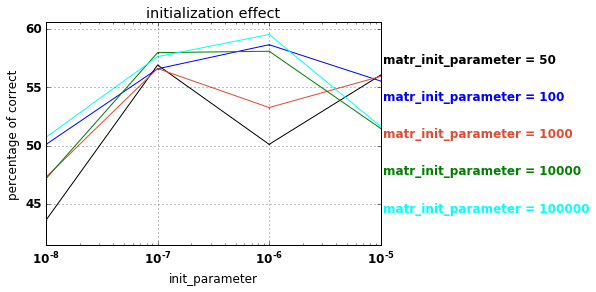

In [11]:
plot_data, _ = initialization_plots.one_key_layout_data('HM_LSTM_3',
                                         'init_parameter',
                                         "matr_init_parameter")
#print(plot_data[0])
initialization_plots.save_layout(plot_data[0],
                    'initialization effect',
                    ['HM_LSTM3', 'init_tuning', 'plots'],
                    'nn128is0.5sg0.5shl1000',
                     plot_options=plot_options)
initialization_plots.draw(plot_data[0], 'initialization effect', plot_options=plot_options)

In [13]:
var = 'aaa'
if isinstance(var, str):
    print(True)
else:
    print(False)

True


In [12]:
    def split_to_path_name(path):
        parts = path.split('/')
        name = parts[-1]
        path = '/'.join(parts[:-1])
        return path, name

In [13]:
path, name = split_to_path_name('bbbb.pickle')
print(path == '')
print(name)

True
bbbb.pickle


In [15]:
folder_name = 'peganov/HM_LSTM_fixed/track_nan'
pickle_file = 'track_nan.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
    dictionary = pickle.load(f)
    five_input = dictionary['self.train_input_print'][0]
    ten_input = dictionary['self.train_input_print'][1]
    five_boundaries = dictionary['self.boundaries_for_plot'][0]
    ten_boundaries = dictionary['self.boundaries_for_plot'][1]

In [16]:
def transform_to_boundaries(nparray):
    nparray[nparray > 0.] = 1.
    nparray[nparray < 0.] = 0.
    return nparray

In [17]:
def transform_to_double_list(nparray):
    length = nparray.shape[0]
    double_list = [list(), list()]
    for i in range(length):
        double_list[0].append(nparray[i, 0])
        double_list[1].append(nparray[i, 1])
    return double_list
        
    

In [18]:
five_boundaries = transform_to_double_list(five_boundaries)
ten_boundaries = transform_to_double_list(ten_boundaries)

In [19]:
print(five_boundaries)
print(ten_boundaries)
print(five_input)
print(ten_input)

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
 towards large businesses and 
leInsider and PowerPage, were 


In [20]:
from plot_module import text_boundaries_plot

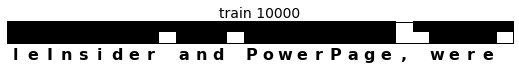

In [22]:
text_boundaries_plot(ten_input, ten_boundaries, 'train 10000', ['HM_LSTM', 'server', 'plotting_check', 'plots'], 'train_10000.png', show=True)

In [1]:

# In[8]:


model = HM_LSTM(64,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 10,
                 3,
                 [56, 59, 62],
                 1.,               # init_slope
                 0.1,                  # slope_growth
                 1000,
                 train_text,
                 valid_text,
                init_parameter=1e-7,
                 matr_init_parameter=10000)


# In[9]:

summary_dict = {'summaries_collection_frequency': 10,
                'summary_tensors': ["self.control_dictionary['embeddings_matrix_variable']",
                                    "self.control_dictionary['HM_LSTM_matrix_0']",
                                    "self.control_dictionary['HM_LSTM_bias_0']",
                                    "self.control_dictionary['HM_LSTM_matrix_1']",
                                    "self.control_dictionary['HM_LSTM_bias_1']",
                                    "self.control_dictionary['HM_LSTM_matrix_2']",
                                    "self.control_dictionary['HM_LSTM_bias_2']",
                                    "self.control_dictionary['output_gates_weights']",
                                    "self.control_dictionary['output_embedding_weights']",
                                    "self.control_dictionary['output_embedding_bias']",
                                    "self.control_dictionary['output_weights']",
                                    "self.control_dictionary['output_bias']"]}

saved_state_templ = "'train_1_saved_state_layer%s_number%s'"

for i in range(model._num_layers):
    for j in range(2):
        summary_dict['summary_tensors'].append('self.control_dictionary[' + saved_state_templ % (i, j) + ']')
for layer_idx in range(model._num_layers):
    summary_dict['summary_tensors'].append("self.control_dictionary['self.L2_forget_gate[%s]']"%layer_idx)


logdir = "peganov/HM_LSTM/track_nan/logging/first_log"
model.run(1,                # number of times learning_rate is decreased
          0.9,              # a factor by which learning_rate is decreased
            10,            # each 'train_frequency' steps loss and percent correctly predicted letters is calculated
            10,             # minimum number of times loss and percent correctly predicted letters are calculated while learning (train points)
            3,              # if during half total spent time loss decreased by less than 'stop_percent' percents learning process is stopped
            1,              # when train point is obtained validation may be performed
            3,             # when train point percent is calculated results got on averaging_number chunks are averaged
          fixed_number_of_steps=101,
            add_operations=['self.train_hard_sigm_arg'],
          add_text_operations=['self.train_input_print'],
           print_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            validation_add_operations = ['self.sigm_arg'],
            num_validation_prints=100,
          validation_example_length=100, 
           #debug=True,
            print_intermediate_results = True,
            collection_operations=[('self.train_input_print', 'text'), ('self.train_hard_sigm_arg', 'number')],
           collection_steps=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],

            path_to_file_for_saving_collection='peganov/HM_LSTM/track_nan/track_nan.pickle',          # all add operations results will be added to a dictionary which will pickled
          path_to_file_for_saving_prints='peganov/HM_LSTM/track_nan/track_nan.txt',
           save_path="peganov/HM_LSTM/track_nan/variables",
             summarizing_logdir=logdir,
            summary_dict=summary_dict)
results_GL = list(model._results)
text_list, boundary_list = model.run_for_analitics(model.get_boundaries,
                                                'peganov/HM_LSTM/track_nan/variables',
                                                [10, 75, None])

for i in range(4):
    text_boundaries_plot(text_list[i],
                            boundary_list[i],
                            'boundaries by layer',
                            ['peganov', 'HM_LSTM', 'track_nan', 'plots'],
                            'plot#%s' % i,
                            show=False)

folder_name = 'peganov/HM_LSTM/track_nan'
file_name = 'track_nan_result.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

NameError: name 'HM_LSTM' is not defined

In [ ]:
folder_name = 'HM_LSTM/HM_LSTM_basic/nn128is0.5sg0.5shl1000'
pickle_file = 'nn128is0.5sg0.5shl1000.pickle'
init_parameters=[1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
matr_init_parameters=[50., 100., 1000., 10000., 100000., 1000000.]
results_GL = list()
for init_parameter_value in init_parameters:
    for matr_init_parameter_value in matr_init_parameters:
        name_of_run = 'ip%s_imp%s' % (init_parameter_value, matr_init_parameter_value)
        with open(folder_name + '/' + name_of_run + '/' + name_of_run + '.pickle', 'rb') as f:
            save = pickle.load(f)
            result = save['results_GL']
            results_GL.append(result)
            del save  # hint to help gc free up memory

In [ ]:
from plot_module import ComparePlots
plot_options = {'x': 'log'}

initialization_plots = ComparePlots('HM_LSTM')
initialization_plots.add_network(results_GL, model._indices)

In [ ]:
plot_data, _ = initialization_plots.one_key_layout_data('HM_LSTM_3',
                                         'init_parameter',
                                         "matr_init_parameter")
#print(plot_data[0])
initialization_plots.save_layout(plot_data[0],
                    'initialization effect',
                    ['HM_LSTM_basic', 'nn128is0.5sg0.5shl1000'],
                    'nn128is0.5sg0.5shl1000',
                     plot_options=plot_options)
initialization_plots.draw(plot_data[0], 'initialization effect', plot_options=plot_options)